In [34]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ucimlrepo import fetch_ucirepo
from tabulate import tabulate

In [35]:
# fetch dataset 
air_quality = fetch_ucirepo(id=360) 
X = air_quality.data.features 
y = air_quality.data.targets
df = pd.concat([X, y], axis=1)
# print(df.head(20))

# Data Preprocessing
df.replace(-200, np.nan, inplace=True) 
num_cols = df.select_dtypes(include=np.number).columns
df[num_cols] = df[num_cols].replace(-200, np.nan) 
df[num_cols] = (df[num_cols].ffill() + df[num_cols].bfill()) / 2 # Fill numeric columns with avg of bfill ffill

# Merge Date and Time into timestamp
df['timestamp'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df.set_index('timestamp', inplace=True)
df.drop(columns=['Date','Time'], inplace=True)
df_unnormalised = df.copy()
# Normalise
df[num_cols] = (df[num_cols] - df[num_cols].mean()) / df[num_cols].std()
# Dervied features
df['hour'], df['weekday'], df['month'] = df.index.hour, df.index.weekday, df.index.month

targets = [c for c in df.columns if '(GT)' in c]
non_targets = [c for c in df.columns if '(GT)' not in c]

+---------------+---------+-----------+----------+----------+-----------+-----------+-----------+----------+
|               |   count |      mean |      std |      min |       25% |       50% |       75% |      max |
|---------------+---------+-----------+----------+----------+-----------+-----------+-----------+----------|
| CO(GT)        |    9357 |    2.1306 |   1.413  |   0.1    |    1.1    |    1.8    |    2.95   |   11.9   |
| PT08.S1(CO)   |    9357 | 1103.06   | 217.452  | 647      |  937      | 1069      | 1237      | 2040     |
| NMHC(GT)      |    1231 |  235.735  | 200.979  |   7      |   89.5    |  154      |  389.5    | 1189     |
| C6H6(GT)      |    9357 |   10.1792 |   7.4829 |   0.1    |    4.5    |    8.4    |   14      |   63.7   |
| PT08.S2(NMHC) |    9357 |  942.143  | 267.182  | 383      |  737      |  914      | 1118      | 2214     |
| NOx(GT)       |    9357 |  241.922  | 202.736  |   2      |   96      |  180.5    |  327      | 1479     |
| PT08.S3(NOx)  |  

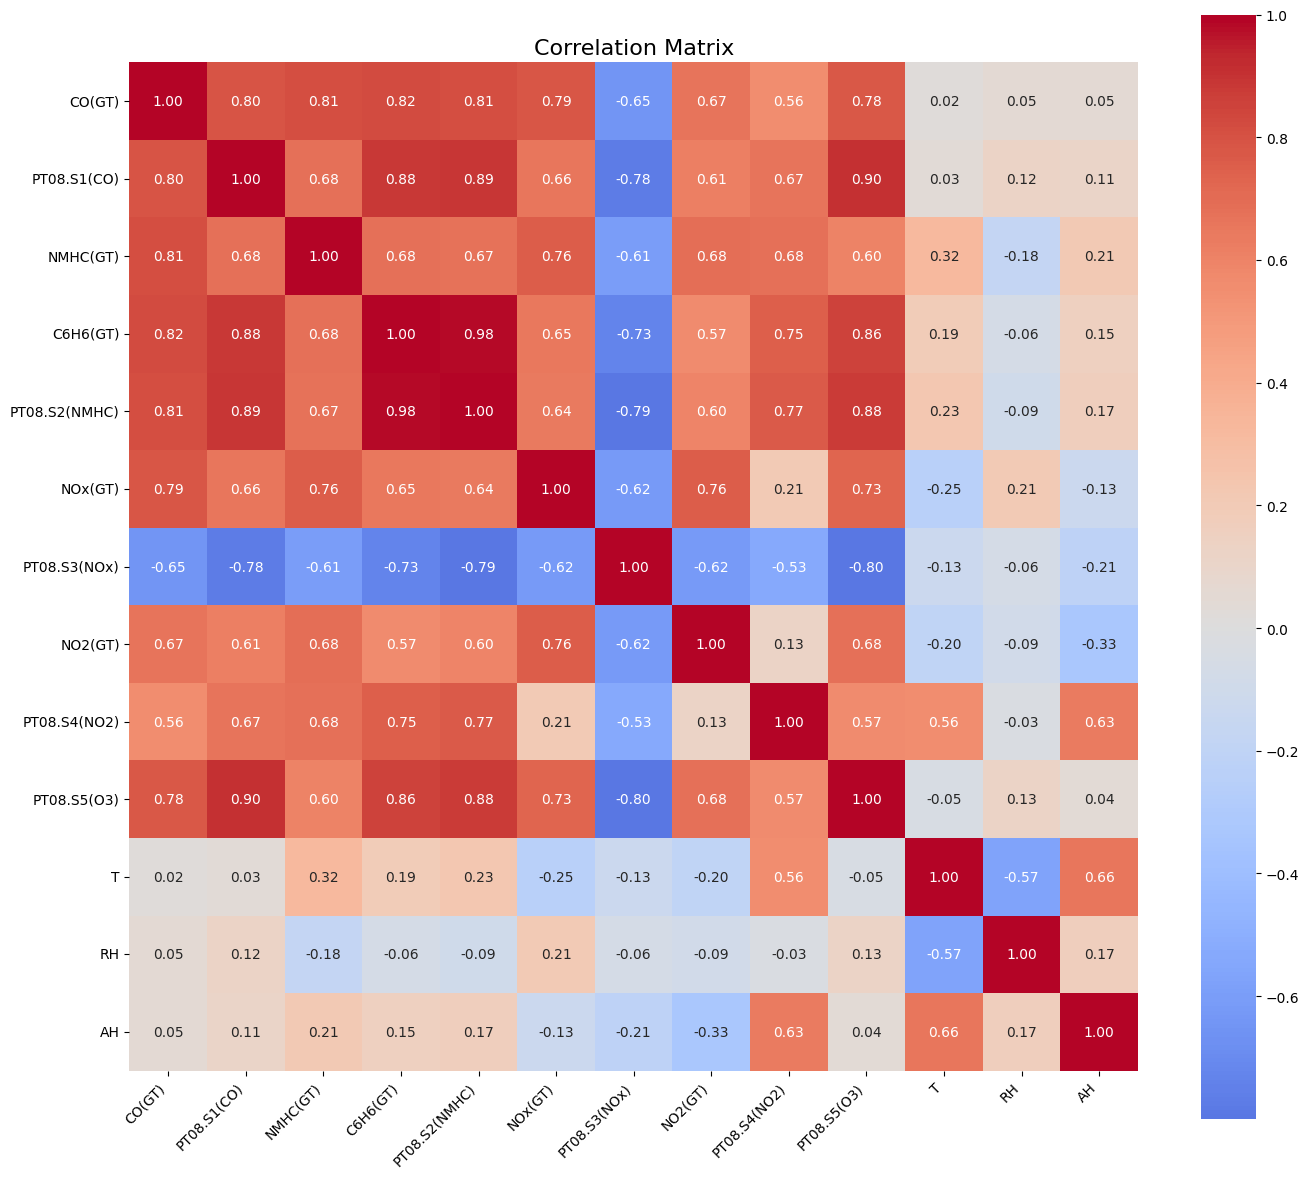

In [36]:
# Summary statics and correlation heatmap
exc = ['hour', 'weekday', 'month']
numericCols = [c for c in df_unnormalised.select_dtypes(include='number').columns if c not in exc]
summary_stats = df_unnormalised[numericCols].describe().T
summary_stats = summary_stats.round(4)
print(tabulate(summary_stats, headers='keys', tablefmt='psql'))

corr_matrix = df[num_cols].corr()
plt.figure(figsize=(len(num_cols)*0.7 + 5, len(num_cols)*0.7 + 5))  # scale size with number of variables
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0, square=True, cbar_kws={'shrink': 0.8})
plt.title('Correlation Matrix', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

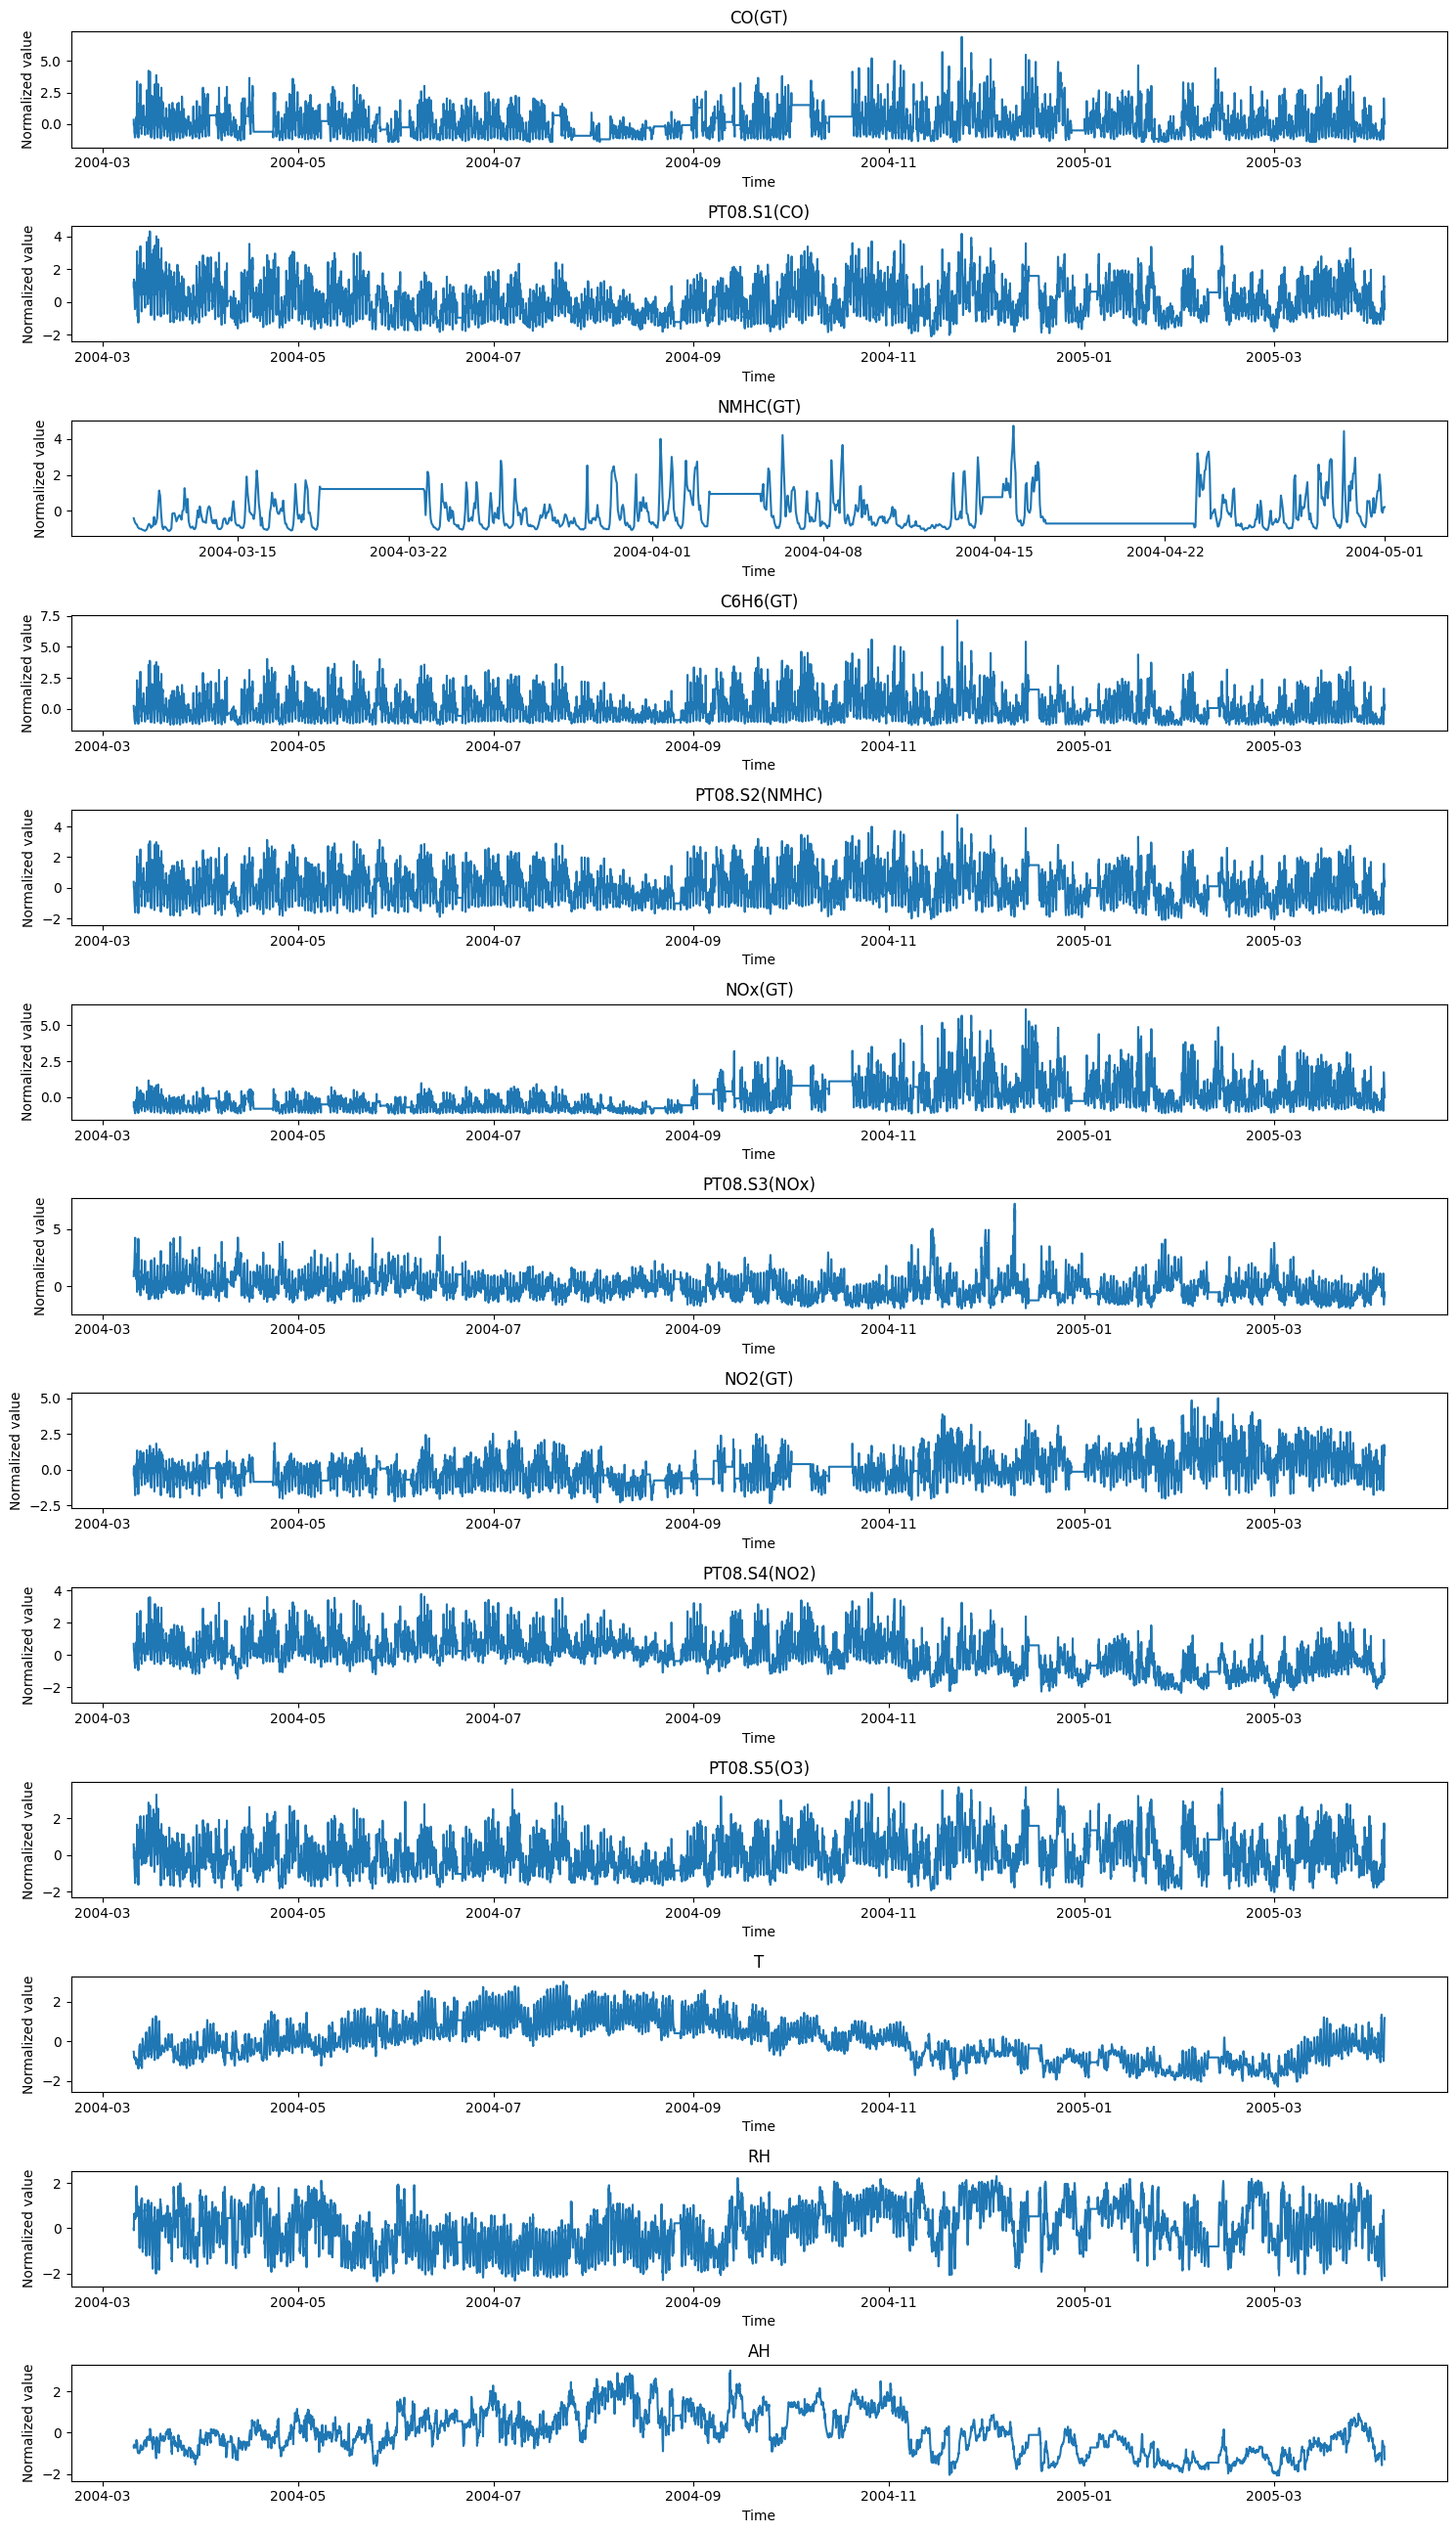

In [37]:

#  Time series plots
plt.figure(figsize=(15, len(num_cols)*2))
for i, col in enumerate(num_cols, 1):
    plt.subplot(len(num_cols), 1, i)
    plt.plot(df.index, df[col])
    plt.title(col)
    plt.xlabel('Time')
    plt.ylabel('Normalized value')
plt.tight_layout()
plt.show()

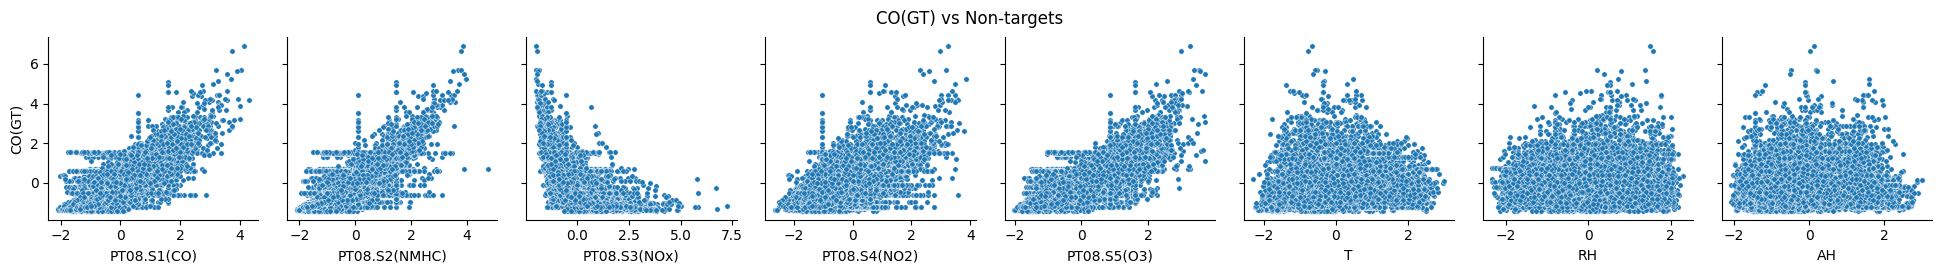

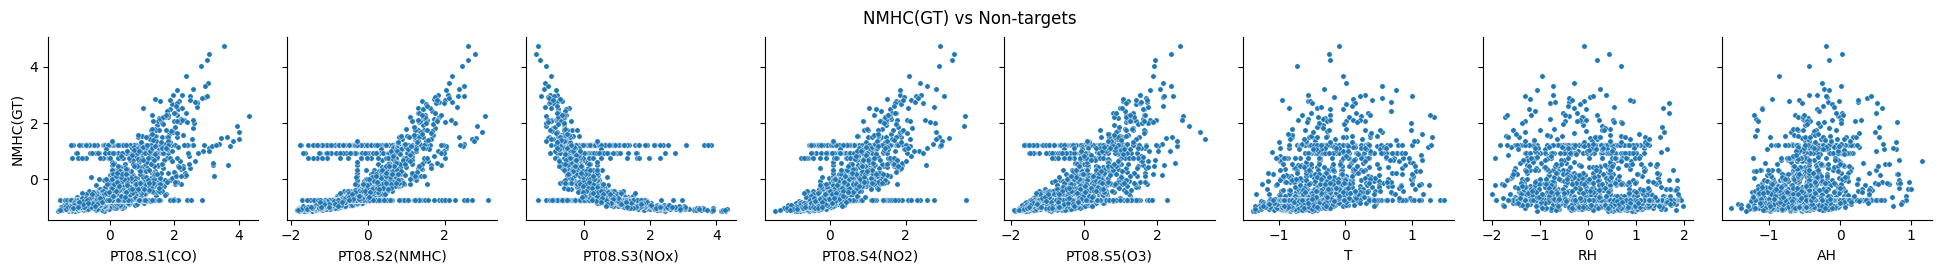

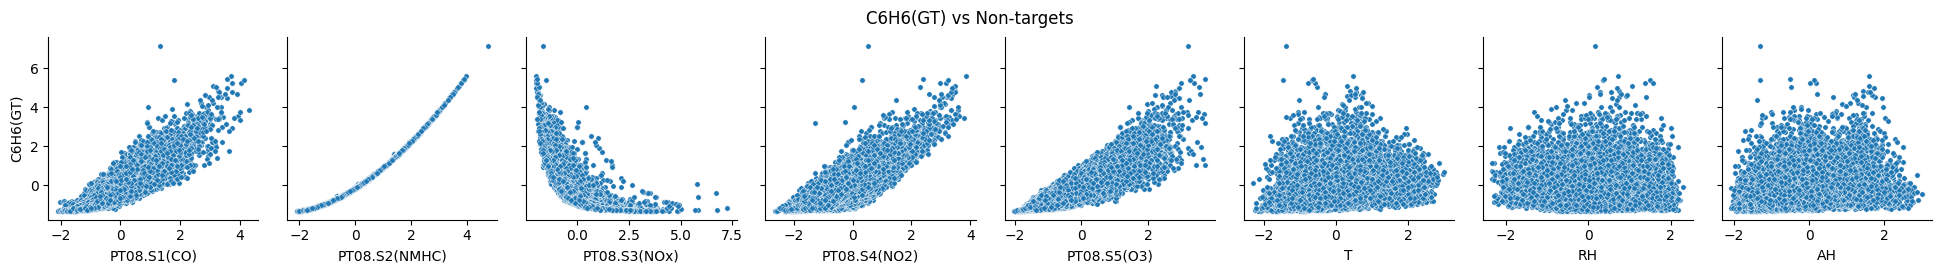

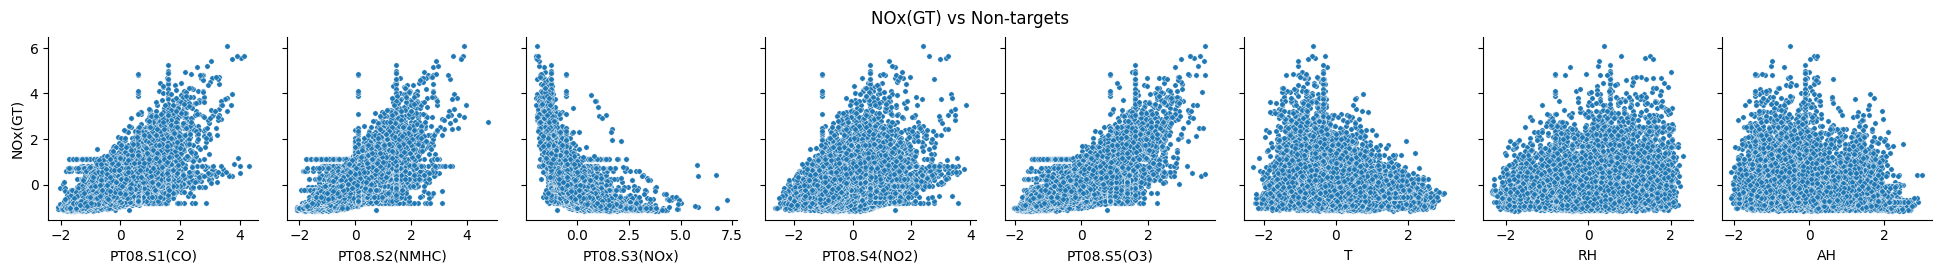

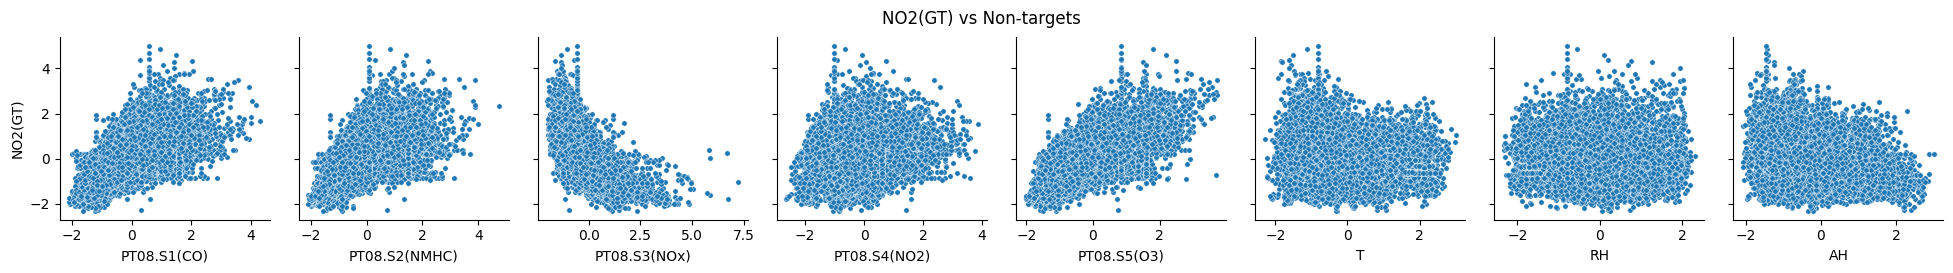

In [38]:
# Scatter plots: Normalised target vs Normalised non-target (excluding derived features)
non_target_cols = [c for c in df.columns if '(GT)' not in c and c not in ['hour','weekday','month']]

for target in targets:
    g = sns.PairGrid(df[non_target_cols + [target]], y_vars=[target], x_vars=non_target_cols, height=2.5)
    g.map(sns.scatterplot, s=15)
    g.fig.suptitle(f'{target} vs Non-targets', y=1.05)
    plt.show()


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:785: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:790: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:785: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:785: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks

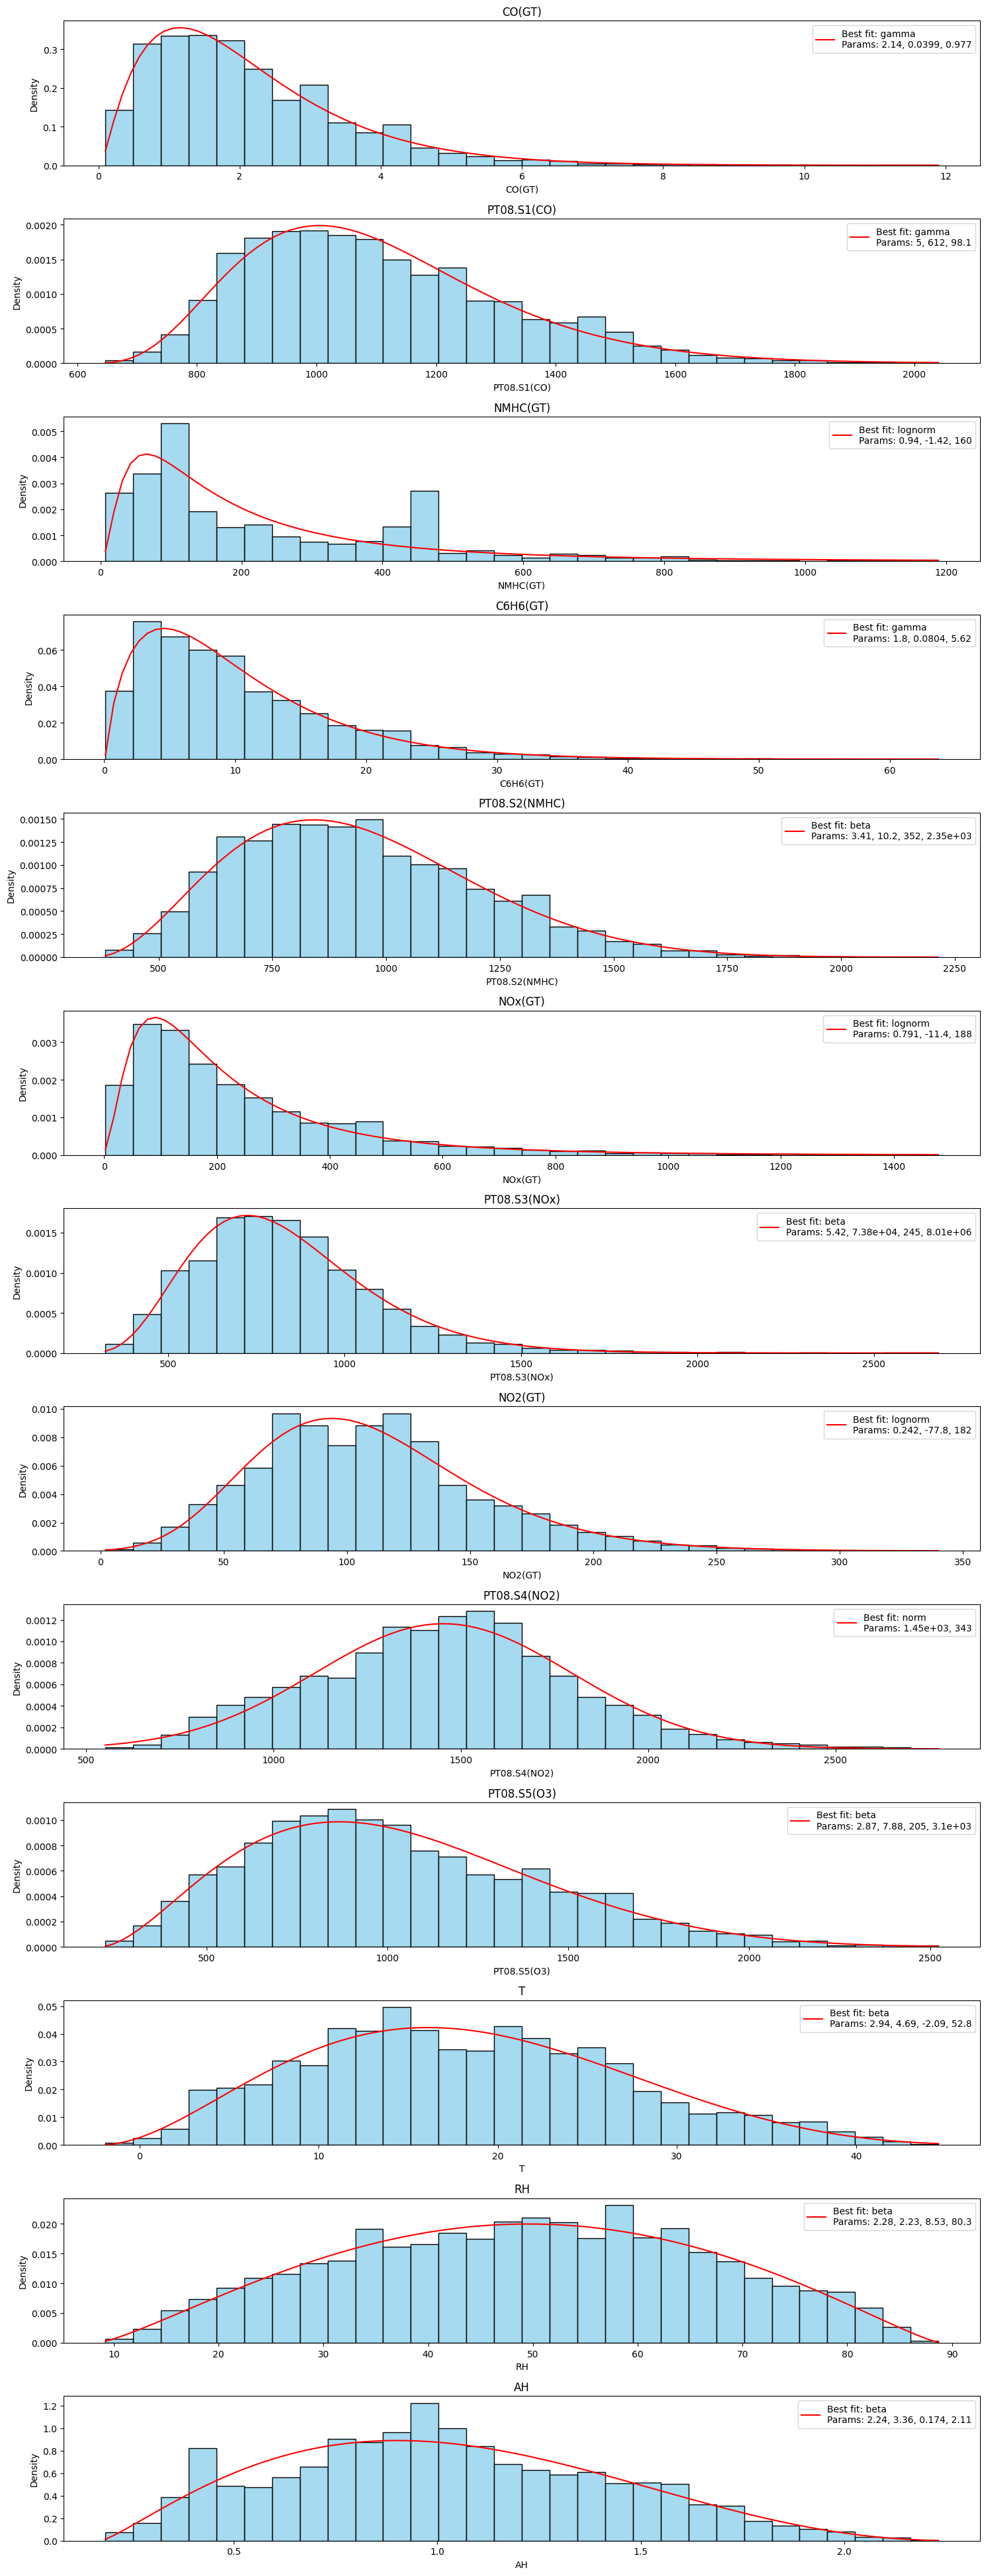

In [39]:
# Distribution fits
# there will be errors because negative temprature values (so we cant fit lognorm and some other dists)
def best_fit(series):
    dist_list = [stats.norm, stats.lognorm, stats.expon, stats.gamma, stats.beta]
    hist, bins = np.histogram(series.dropna(), bins=30, density=True)
    bc = (bins[1:] + bins[:-1])/2
    best_sse = np.inf
    for dist in dist_list:
        params = dist.fit(series.dropna())
        sse = np.sum((hist - dist.pdf(bc, *params))**2)
        if sse < best_sse:
            best_sse, best_fit_name, best_params = sse, dist.name, params
    return best_fit_name, best_params

# use unnormalised data for distribution fitting
original_cols = [c for c in df_unnormalised.columns if c not in ['hour','weekday','month']]

fig, axes = plt.subplots(len(original_cols), 1, figsize=(15, len(original_cols)*3))

for ax, col in zip(axes, original_cols):
    
    series = df_unnormalised[col].dropna()  
    # Histogram
    sns.histplot(series, bins=30, kde=False, stat='density', color='skyblue', ax=ax)
    # Fit distributions
    dist_name, params = best_fit(series)
    x = np.linspace(series.min(), series.max(), 100)
    ax.plot(
        x, 
        getattr(stats, dist_name).pdf(x, *params), 
        'r', 
        label=f"Best fit: {dist_name}\nParams: {', '.join([f'{p:.3g}' for p in params])}"
    )
    ax.set_title(col)
    ax.legend()

plt.tight_layout()
plt.show()
